In [9]:
# Cell 1 — Install deps (no XRootD needed)
!pip -q install "uproot>=5" awkward vector rich tqdm pandas pyarrow fastparquet matplotlib

In [19]:
import uproot
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt


In [10]:
FEATURES = [
"nMuon","nElectron","nJet","MET_pt","MET_phi","MET_sumEt",
"Muon_pt_0","Muon_eta_0","Muon_phi_0",
"Muon_pt_1","Muon_eta_1","Muon_phi_1",
"Electron_pt_0","Electron_eta_0","Electron_phi_0",
"Electron_pt_1","Electron_eta_1","Electron_phi_1",
"Jet_pt_0","Jet_eta_0","Jet_phi_0",
"Jet_pt_1","Jet_eta_1","Jet_phi_1",
"Jet_pt_2","Jet_eta_2","Jet_phi_2",
"Jet_pt_3","Jet_eta_3","Jet_phi_3",
"HT","ST","M_ll","M_jj_01","M_jj_12",
"delta_phi_MET_j0","delta_phi_MET_j1","min_delta_phi_MET_jets",
"delta_R_j0_j1","delta_phi_ll","delta_R_ll",
"Jet_btagDeepB_0","Jet_btagDeepB_1",
"MT_lep_MET","HT_ratio","MET_pt_HT_ratio",
"nJet_pt30","Jet_mass_0","LeadLepton_pt","sum_pt_leptons"
]


In [11]:
import uproot
import pandas as pd
import glob

def find_tree_recursive(file):
    """Find first TTree anywhere inside ROOT file."""
    for key, obj in file.items(recursive=True):
        if isinstance(obj, uproot.behaviors.TTree.TTree):
            return obj
    return None


def load_root_folder_chunked(
        folder,
        label,
        source,
        step_size=50000,
        max_files=None,
        max_events=None):

    files = sorted(glob.glob(folder + "/*.root"))
    if max_files:
        files = files[:max_files]

    dfs = []
    total_events = 0

    print(f"\nLoading {source} from {len(files)} files")

    for i, f in enumerate(files):

        print(f"  File {i+1}/{len(files)}")

        with uproot.open(f) as file:

            tree = find_tree_recursive(file)

            if tree is None:
                print("   No tree found, skipping")
                continue

            print("   Found tree:", tree.name)

            for batch in tree.iterate(
                    FEATURES,
                    library="pd",
                    step_size=step_size):

                batch["label"] = label
                batch["source"] = source
                dfs.append(batch)

                total_events += len(batch)

                if max_events and total_events >= max_events:
                    print(f"Reached event limit: {max_events}")
                    return pd.concat(dfs, ignore_index=True).iloc[:max_events]

    if len(dfs) == 0:
        print("No data loaded!")
        return pd.DataFrame()

    return pd.concat(dfs, ignore_index=True)


In [12]:
real = load_root_folder_chunked(
    cms2016G,
    -1,
    "REAL",
    max_files=1
)

real.head()



Loading REAL from 1 files
  File 1/1
   No tree found, skipping
No data loaded!


""


In [13]:
cmsderived = "/kaggle/input/datasets/katakuricharlotte/cms-derivedroot/derivedroot"
cms2016G   = "/kaggle/input/datasets/hiteshrs/cms2016g29-5785/processed_events"

dy   = load_root_folder_chunked(f"{cmsderived}/DYJetsToLL_0J_TuneCP5", 0, "DY", max_files=2)
wj   = load_root_folder_chunked(f"{cmsderived}/WJetsToLNu_TuneCP5", 0, "WJets", max_files=2)
tt   = load_root_folder_chunked(f"{cmsderived}/TTJets_TuneCP5", 0, "TT", max_files=2)
susy = load_root_folder_chunked(f"{cmsderived}/SMS-TChiWZ_ZToLL", 1, "SUSY", max_files=2)
real = load_root_folder_chunked(cms2016G, -1, "REAL", max_files=2)



Loading DY from 2 files
  File 1/2
   Found tree: Events
  File 2/2
   Found tree: Events

Loading WJets from 2 files
  File 1/2
   Found tree: Events
  File 2/2
   Found tree: Events

Loading TT from 2 files
  File 1/2
   Found tree: Events
  File 2/2
   Found tree: Events

Loading SUSY from 2 files
  File 1/2
   Found tree: Events
  File 2/2
   Found tree: Events

Loading REAL from 2 files
  File 1/2
   No tree found, skipping
  File 2/2
   No tree found, skipping
No data loaded!


In [14]:
df = pd.concat([dy, wj, tt, susy, real], ignore_index=True)

print(df.shape)
df.head()


(11615070, 52)


,nMuon,nElectron,nJet,MET_pt,MET_phi,MET_sumEt,Muon_pt_0,Muon_eta_0,Muon_phi_0,Muon_pt_1,...,Jet_btagDeepB_1,MT_lep_MET,HT_ratio,MET_pt_HT_ratio,nJet_pt30,Jet_mass_0,LeadLepton_pt,sum_pt_leptons,label,source
0,1,0,1,41.720829,1.062500,476.0,34.193535,-2.293945,-2.644043,0.0,...,0.000000,72.546478,0.502039,0.991877,1,1.962891,34.193535,0.0,0,DY
1,0,1,2,13.133373,2.501465,430.5,0.000000,0.000000,0.000000,0.0,...,-1.000000,3.186002,0.852188,0.173449,2,3.818359,29.832355,0.0,0,DY
2,0,0,3,14.121712,-2.394043,812.0,0.000000,0.000000,0.000000,0.0,...,-1.000000,0.000000,0.000000,0.000000,0,4.910156,0.000000,0.0,0,DY
3,0,1,2,55.432575,2.975098,608.0,0.000000,0.000000,0.000000,0.0,...,0.494385,40.623421,0.487305,1.052101,1,7.562500,8.107705,0.0,0,DY
4,0,1,2,18.365170,-1.846191,950.5,0.000000,0.000000,0.000000,0.0,...,-1.000000,16.759590,0.000000,0.000000,0,1.876953,19.615549,0.0,0,DY


In [15]:
df.memory_usage(deep=True).sum() / 1024**2


np.float64(2883.908643722534)

In [16]:
for col in df.select_dtypes("float"):
    df[col] = df[col].astype("float32")

for col in df.select_dtypes("int"):
    df[col] = df[col].astype("int16")


In [17]:
df.info()
df.describe().T.head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11615070 entries, 0 to 11615069
Data columns (total 52 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   nMuon                   int16  
 1   nElectron               int16  
 2   nJet                    int16  
 3   MET_pt                  float32
 4   MET_phi                 float32
 5   MET_sumEt               float32
 6   Muon_pt_0               float32
 7   Muon_eta_0              float32
 8   Muon_phi_0              float32
 9   Muon_pt_1               float32
 10  Muon_eta_1              float32
 11  Muon_phi_1              float32
 12  Electron_pt_0           float32
 13  Electron_eta_0          float32
 14  Electron_phi_0          float32
 15  Electron_pt_1           float32
 16  Electron_eta_1          float32
 17  Electron_phi_1          float32
 18  Jet_pt_0                float32
 19  Jet_eta_0               float32
 20  Jet_phi_0               float32
 21  Jet_pt_1                float

,count,mean,std,min,25%,50%,75%,max
nMuon,11615070.0,0.542233,0.805454,0.000000,0.000000,0.00000,1.000000,1.800000e+01
nElectron,11615070.0,0.584918,0.837444,0.000000,0.000000,0.00000,1.000000,1.000000e+01
nJet,11615070.0,3.796585,2.683769,0.000000,2.000000,3.00000,5.000000,2.400000e+01
MET_pt,11615070.0,50.354286,60.849411,0.004556,20.592128,34.65291,56.721979,8.488409e+03
MET_phi,11615070.0,0.017631,1.871074,-3.141602,-1.687256,0.03875,1.719727,3.141602e+00
MET_sumEt,11615070.0,1150.164062,452.170898,15.226562,816.500000,1104.00000,1431.000000,1.053600e+04
Muon_pt_0,11615070.0,14.714487,2662.302979,0.000000,0.000000,0.00000,11.106484,7.780808e+06
Muon_eta_0,11615070.0,0.001555,0.808886,-10.152344,0.000000,0.00000,0.000000,1.183984e+01
Muon_phi_0,11615070.0,0.000311,1.113438,-3.141602,0.000000,0.00000,0.000000,3.141602e+00
Muon_pt_1,11615070.0,2.531417,18.698387,0.000000,0.000000,0.00000,0.000000,4.471758e+04


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 12,

    "axes.labelsize": 9,
    "axes.titlesize": 9,
    "axes.linewidth": 1.2,

    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,

    "legend.fontsize": 11,
    "legend.frameon": True,
    "legend.edgecolor": "0.4",

    "grid.linestyle": ":",
    "grid.linewidth": 0.7,
    "grid.alpha": 0.8,
})

def paper_axes(ax):
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle=":", linewidth=0.8)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.7)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    ax.tick_params(which="both", direction="in", top=True, right=True)


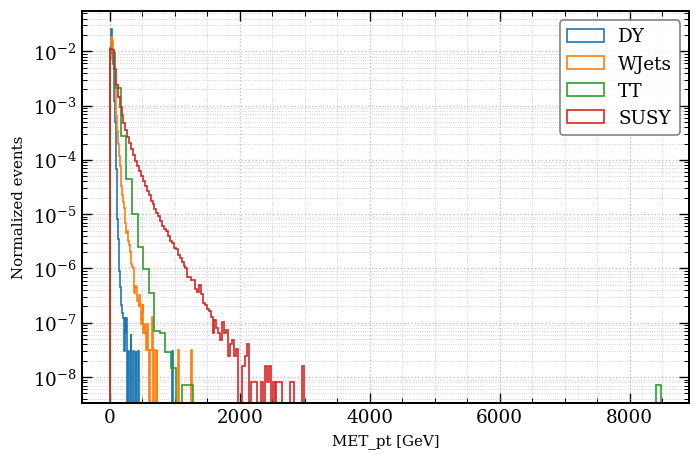

In [40]:
fig, ax = plt.subplots(figsize=(6,4), dpi=120)

for s in ["DY","WJets","TT","SUSY"]:
    subset = df[df.source==s]
    ax.hist(subset["MET_pt"], bins=100, histtype="step", linewidth=1,
            density=True, label=s)

ax.set_yscale("log")
ax.set_xlabel("MET_pt [GeV]")
ax.set_ylabel("Normalized events")
ax.legend()

paper_axes(ax)
fig.tight_layout()

fig.savefig("/kaggle/working/met_comparison.jpg", dpi=300)
plt.show()


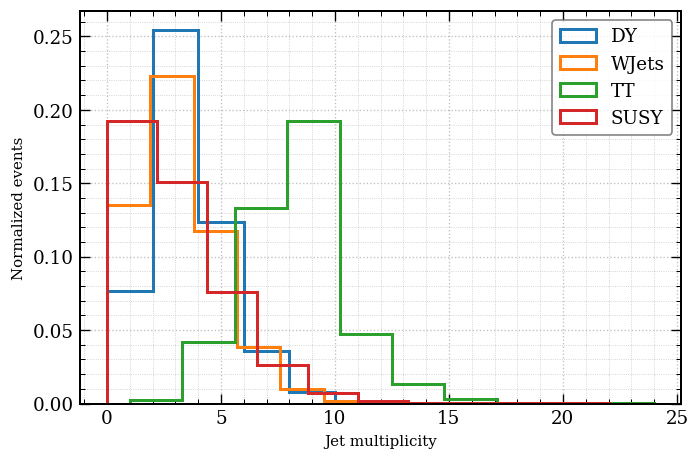

In [41]:
fig, ax = plt.subplots(figsize=(6,4), dpi=120)

for s in ["DY","WJets","TT","SUSY"]:
    subset = df[df.source==s]
    ax.hist(subset["nJet"], bins=10, histtype="step", linewidth=1.1,
            density=True, label=s)

ax.set_xlabel("Jet multiplicity")
ax.set_ylabel("Normalized events")
ax.legend()

paper_axes(ax)
fig.tight_layout()

fig.savefig("/kaggle/working/njet_comparison.jpg", dpi=300)
plt.show()


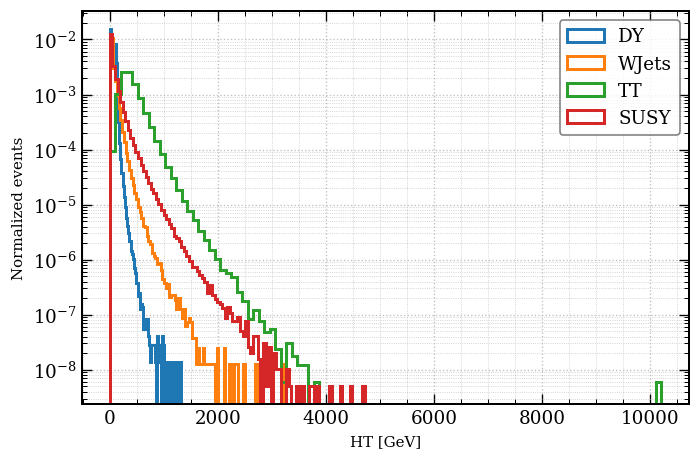

In [42]:
fig, ax = plt.subplots(figsize=(6,4), dpi=120)

for s in ["DY","WJets","TT","SUSY"]:
    subset = df[df.source==s]
    ax.hist(subset["HT"], bins=100, histtype="step", linewidth=1,
            density=True, label=s)

ax.set_yscale("log")
ax.set_xlabel("HT [GeV]")
ax.set_ylabel("Normalized events")
ax.legend()

paper_axes(ax)
fig.tight_layout()

fig.savefig("/kaggle/working/ht_comparison.jpg", dpi=300)
plt.show()


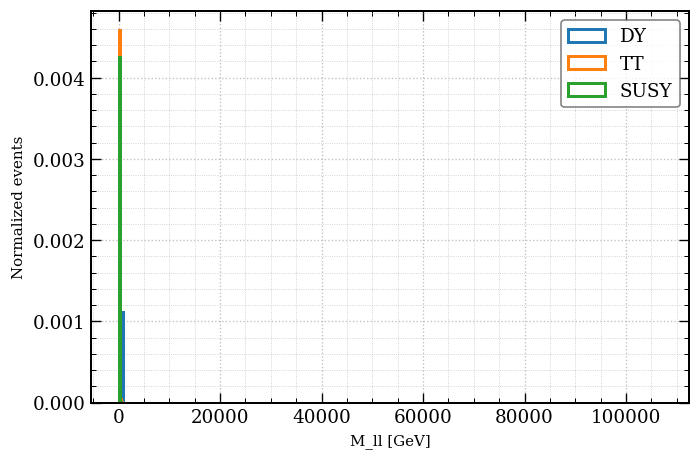

In [43]:
fig, ax = plt.subplots(figsize=(6,4), dpi=120)

for s in ["DY","TT","SUSY"]:
    subset = df[df.source==s]
    ax.hist(subset["M_ll"], bins=120, histtype="step", linewidth=1.5,
            density=True, label=s)

ax.set_xlabel("M_ll [GeV]")
ax.set_ylabel("Normalized events")
ax.legend()

paper_axes(ax)
fig.tight_layout()

fig.savefig("/kaggle/working/dilepton_mass.jpg", dpi=300)
plt.show()


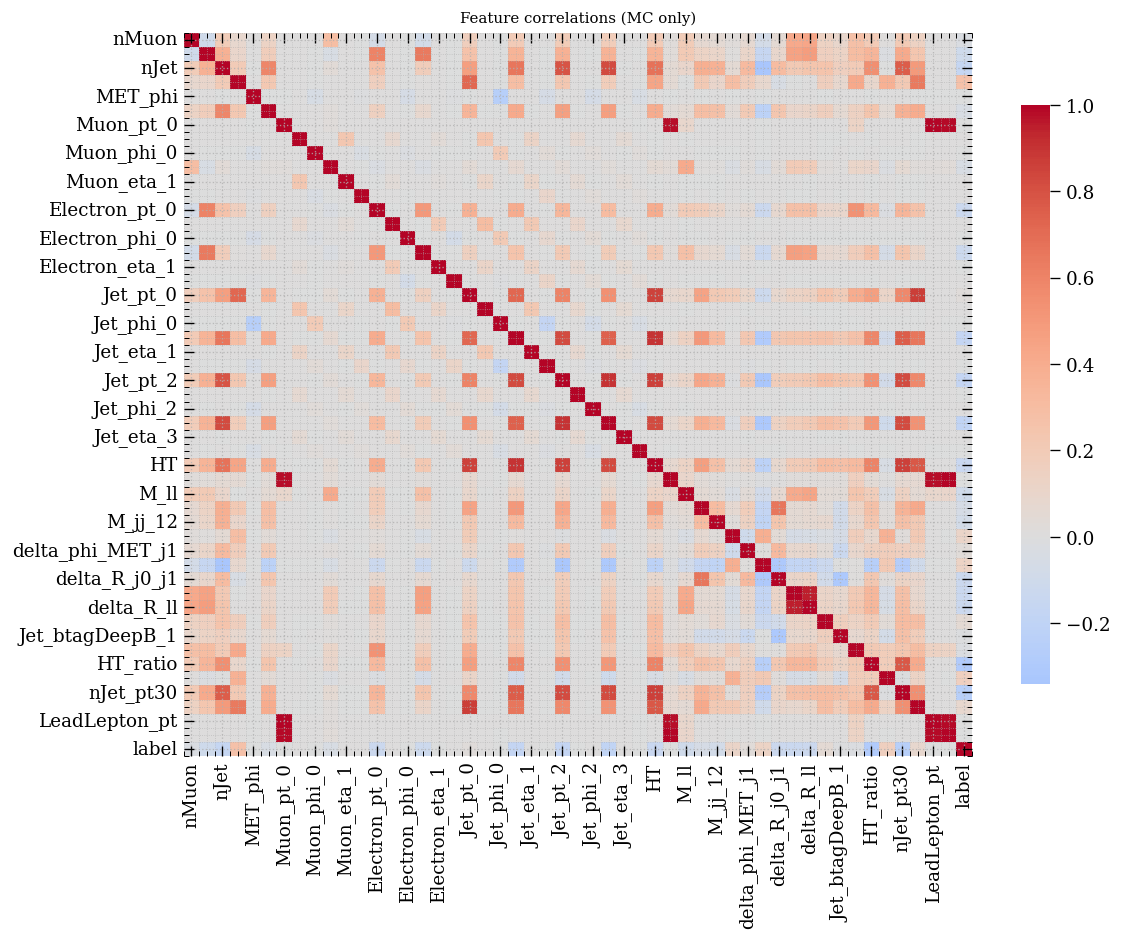

In [44]:
fig, ax = plt.subplots(figsize=(10,8), dpi=120)

corr = df[df.label!=-1].corr(numeric_only=True)

sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    ax=ax,
    cbar_kws={"shrink":0.8}
)

ax.set_title("Feature correlations (MC only)")

paper_axes(ax)
fig.tight_layout()

fig.savefig("/kaggle/working/feature_correlation.jpg", dpi=300)
plt.show()


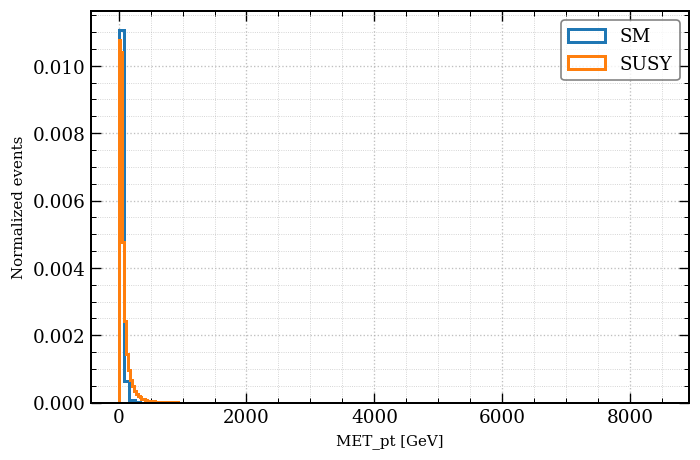

In [45]:
susy_df = df[df.label==1]
sm_df   = df[df.label==0]

fig, ax = plt.subplots(figsize=(6,4), dpi=120)

ax.hist(sm_df["MET_pt"], bins=100, histtype="step",
        linewidth=1.8, density=True, label="SM")

ax.hist(susy_df["MET_pt"], bins=100, histtype="step",
        linewidth=1.8, density=True, label="SUSY")

ax.set_xlabel("MET_pt [GeV]")
ax.set_ylabel("Normalized events")
ax.legend()

paper_axes(ax)
fig.tight_layout()

fig.savefig("/kaggle/working/sm_vs_susy_met.jpg", dpi=300)
plt.show()
